# 0. Setup

## 0.1. Libraries

In [1]:
# pip install tifffile

In [2]:
# General utilities
import os
import pandas as pd
import numpy as np
import torch
from pathlib import Path
from collections import defaultdict

# Image processing
from PIL import Image
import tifffile

# Custom library
from library.eda.eda import DataExplorer
from library.visualizations.indices_visualizer import IndicesVisualizer
from library.utilities.build_path_dictionary import build_path_dictionary

from library.utilities.read_png_to_numpy import read_png_to_numpy
from library.utilities.read_tiff_to_numpy import read_tiff_to_numpy
from library.utilities.read_png_to_torch import read_png_to_torch
from library.utilities.read_tiff_to_torch import read_tiff_to_torch

## 0.2. Paths and initialization of variables

In [3]:
# input_labelled_dir = '/media/pablo/Shared files/data/Satellite_burned_area_dataset'  # Adjust this path as needed
# input_inference_dir = os.path.join('..', 'catalunya_fire_imgs')

In [4]:
# input_dir = '/media/pablo/Shared files/data/Satellite_burned_area_dataset'  # Adjust this path as needed
input_dir = 'C:/Users/blanc/OneDrive/Desktop/DSDM/3-ImageProcessing/FINAL_HW/'

tiles_path = os.path.join(input_dir, 'tiled_labelled_dataset')
full_images_path = os.path.join(input_dir, 'Satellite_burned_area_dataset')

tiles_dict = build_path_dictionary(tiles_path)
full_images_dict = build_path_dictionary(full_images_path)

In [5]:
# CHECK DICTIONARIES
print("------------ Tiles Dictionary: ------------")
for key, paths in tiles_dict.items():
    print(f"{key}: {len(paths)} files")
    if paths:  # Show first few examples
        print(f"  Examples: {paths[:3]}")
    for path in paths:
        if Path(path).exists() == False:
            print(f"  !!! Wrong path: {path}")
    print()

print("------------ Full Images Dictionary: ------------")
for key, paths in full_images_dict.items():
    print(f"{key}: {len(paths)} files")
    if paths:  # Show first few examples
        print(f"  Examples: {paths[:3]}")
    for path in paths:
        if Path(path).exists() == False:
            print(f"  !!! Wrong path: {path}")
    print()

------------ Tiles Dictionary: ------------
coverages: 6298 files
  Examples: ['C:/Users/blanc/OneDrive/Desktop/DSDM/3-ImageProcessing/FINAL_HW/tiled_labelled_dataset\\EMSR207_01MIRANDADOCORVO_02GRADING_MAP_v2_vector\\coverages\\sentinel1_2017-07-01_coverage_tile_0_0.png', 'C:/Users/blanc/OneDrive/Desktop/DSDM/3-ImageProcessing/FINAL_HW/tiled_labelled_dataset\\EMSR207_01MIRANDADOCORVO_02GRADING_MAP_v2_vector\\coverages\\sentinel1_2017-07-01_coverage_tile_0_1.png', 'C:/Users/blanc/OneDrive/Desktop/DSDM/3-ImageProcessing/FINAL_HW/tiled_labelled_dataset\\EMSR207_01MIRANDADOCORVO_02GRADING_MAP_v2_vector\\coverages\\sentinel1_2017-07-01_coverage_tile_0_2.png']

masks: 3374 files
  Examples: ['C:/Users/blanc/OneDrive/Desktop/DSDM/3-ImageProcessing/FINAL_HW/tiled_labelled_dataset\\EMSR207_01MIRANDADOCORVO_02GRADING_MAP_v2_vector\\masks\\EMSR207_01MIRANDADOCORVO_02GRADING_MAP_v2_vector_mask_tile_0_0.tiff', 'C:/Users/blanc/OneDrive/Desktop/DSDM/3-ImageProcessing/FINAL_HW/tiled_labelled_dataset\

In [6]:
train_example_img_path = os.path.join(input_dir, 'Satellite_burned_area_dataset/Satellite_burned_area_dataset_part1/EMSR207_04AVELAR_02GRADING_MAP_v2_vector/sentinel2_2017-07-04.tiff')
train_example_mask_path = os.path.join(input_dir, 'Satellite_burned_area_dataset/Satellite_burned_area_dataset_part1/EMSR207_04AVELAR_02GRADING_MAP_v2_vector/EMSR207_04AVELAR_02GRADING_MAP_v2_vector_mask.png')
# train_example_img_path2
# train_example

test_example_path = os.path.join(input_dir, 'catalunya_fire_imgs/2015/images/sentinel2_2015-07-13_lon3-161_lat42-432.tiff')

train_example_img = read_tiff_to_torch(train_example_img_path)
test_example_img = read_tiff_to_torch(test_example_path)

train_visualizer = IndicesVisualizer(train_example_img_path, train_example_mask_path)
# test_visualizer = IndicesVisualizer(test_example_path)

## 0.3. Notebook description

In this notebook we preprocess the image data to prepare it for training/validation/test and for inference. To that end, we pre-process 2 different sources of data:
1) The labelled dataset from *Luca Colomba, Alessandro Farasin, Simone Monaco, Salvatore Greco, Paolo Garza, Daniele Apiletti, Elena Baralis, and Tania Cerquitelli. 2022. A Dataset for Burned Area Delineation and Severity Estimation from Satellite Imagery. In Proceedings of the 31st ACM International Conference on Information & Knowledge Management (CIKM '22). Association for Computing Machinery, New York, NY, USA, 3893–3897. https://doi.org/10.1145/3511808.3557528*. The dataset can be downloaded from here: https://zenodo.org/records/6597139 (click on "Download all", which will approximately download 14GB worth of images and labels).
2) The inference dataset for the fires in Catalunya, obtained by our own means through the APIs of [Sentinel Hub](https://dataspace.copernicus.eu/analyse/apis/sentinel-hub) (see the notebooks for part 1). 

To that end, in this notebook we follow the the pre-processing steps outlined in the paper (for consistency):
  1) Since our research question focuses on assessing the severity of fires in Catalunya (inference), we will only be using the post-fire satellite imagery (like the authors do for their binary segmentation task).
  2) Generate 512x512 pixel tiles for the labelled train, validation, test and inference data. For images whose size is not a multiple of 512, overlap of tiles is allowed (in order to cover all of the area of the image). 
  3) Additionally, during the training phase, we will randomly shuffle the tiles and apply data augmentation techniques (see the corresponding training notebook).

> The final goal is to train a model that estimates the severity of a wildfire using post-wildfire (1 month after) imagery, and then to run inference with the satellite images from wildfires in Catalunya in the last decade. Severity estimation will be done at the pixel level.

Additionally, within the paper, the authors of the dataset provide additional metadata and a suggestion for the organization of the folds for training/validation:

In [7]:
df = pd.read_csv('satellite_data.csv')

print("Number of rows (different fires) in the DataFrame:", len(df))
print("Columns in the DataFrame:", df.columns.tolist())

df.head()

Number of rows (different fires) in the DataFrame: 73
Columns in the DataFrame: ['folder', 'top_left_long', 'top_left_lat', 'bottom_right_long', 'bottom_right_lat', 'activation_date', 'suggested_pre_date_from', 'suggested_pre_date_to', 'suggested_post_date_from', 'suggested_post_date_to', 'download_period_start', 'download_period_end', 'height', 'width', 'pre_date', 'post_date', 'situation_as_of', 'longitude', 'latitude', 'fold']


,folder,top_left_long,top_left_lat,bottom_right_long,bottom_right_lat,activation_date,suggested_pre_date_from,suggested_pre_date_to,suggested_post_date_from,suggested_post_date_to,download_period_start,download_period_end,height,width,pre_date,post_date,situation_as_of,longitude,latitude,fold
0,EMSR214_05LELAVANDOU_02GRADING_MAP_v1_vector,6.104806,43.342188,6.452223,43.065393,24/07/2017,2017-06-13,2017-07-14,2017-07-24,2017-08-24,24/06/2017,24/08/2017,522,512,14/07/2017 10:30,18/08/2017 10:34,28/07/2017,6.278515,43.203790,purple
1,EMSR207_04AVELAR_02GRADING_MAP_v2_vector,-8.499468,40.026117,-8.307374,39.904662,17/06/2017,2017-05-07,2017-06-07,2017-06-17,2017-07-18,17/05/2017,17/07/2017,512,615,NaN,NaN,20/06/2017,-8.403421,39.965389,coral
2,EMSR207_08CERNACHEDOBONJARDIM_02GRADING_MAP_v2...,-8.307667,39.904662,-8.116087,39.783514,17/06/2017,2017-05-07,2017-06-07,2017-06-17,2017-07-18,17/05/2017,17/07/2017,512,613,NaN,NaN,20/06/2017,-8.211877,39.844088,coral
3,EMSR209_01MOGUER_02GRADING_MAP_v2_vector,-6.847640,37.291966,-6.702477,37.166775,24/06/2017,2017-05-14,2017-06-14,2017-06-24,2017-07-25,24/05/2017,24/07/2017,579,512,01/06/2017 11:12,01/07/2017 11:17,NaN,-6.775058,37.229371,pink
4,EMSR298_02HAMMARSTRAND_02GRADING_MAP_v1_vector,16.361547,63.140440,16.447381,63.099674,16/07/2018,2018-06-05,2018-07-06,2018-07-16,2018-08-16,16/06/2018,16/08/2018,561,512,14/07/2018 10:30,27/07/2018 10:40,NaN,16.404464,63.120057,grey


# 1. Pre-processing the labelled data

"Annotations released by Copernicus specify 5 different severity levels, which were encoded in a greyscale image in range [0 − 255], from no damage to completely destroyed area." Labels have 5 levels of severity (0 = undamaged to 4 = fully destroyed).

Such classes are highly imbalanced: unburnt areas are the 91.9% of the whole images. Focusing on burnt areas only, class 1 covers around the 12%, while class 2 to 4 coverages stay around 30% (1%, 2.25%, 2.35%, and 2.5% of the total, respectively for the 4 classes).

In [8]:
print('CHANNELS:')
for key in tiles_dict.keys():
    photo = tiles_dict[key][0]  # Get the first photo path for each key
    try:
        print(f'{key:<9}: {read_tiff_to_numpy(photo).shape}')
    except Exception:
        print(f'{key:<9}: {read_png_to_numpy(photo).shape}')


CHANNELS:
coverages: (1, 256, 256)
masks    : (1, 256, 256)
sentinel1: (4, 256, 256)
sentinel2: (13, 256, 256)


Value 0.0  : 181,568,338 pixels (82.11 %)
Value 32.0 :  20,882,017 pixels ( 9.44 %)
Value 64.0 :   2,092,836 pixels ( 0.95 %)
Value 128.0:   5,332,509 pixels ( 2.41 %)
Value 192.0:   5,603,916 pixels ( 2.53 %)
Value 255.0:   5,638,848 pixels ( 2.55 %)

Images with only negative pixels: 2128 (63.07%)


c:\Users\blanc\OneDrive\Desktop\DSDM\3-ImageProcessing\FINAL_HW\DL_improc_final_project\library\eda\eda.py:244: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=ordered_class_labels, y=counts, palette=viridis_colors, ax=ax)
c:\Users\blanc\OneDrive\Desktop\DSDM\3-ImageProcessing\FINAL_HW\DL_improc_final_project\library\eda\eda.py:263: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


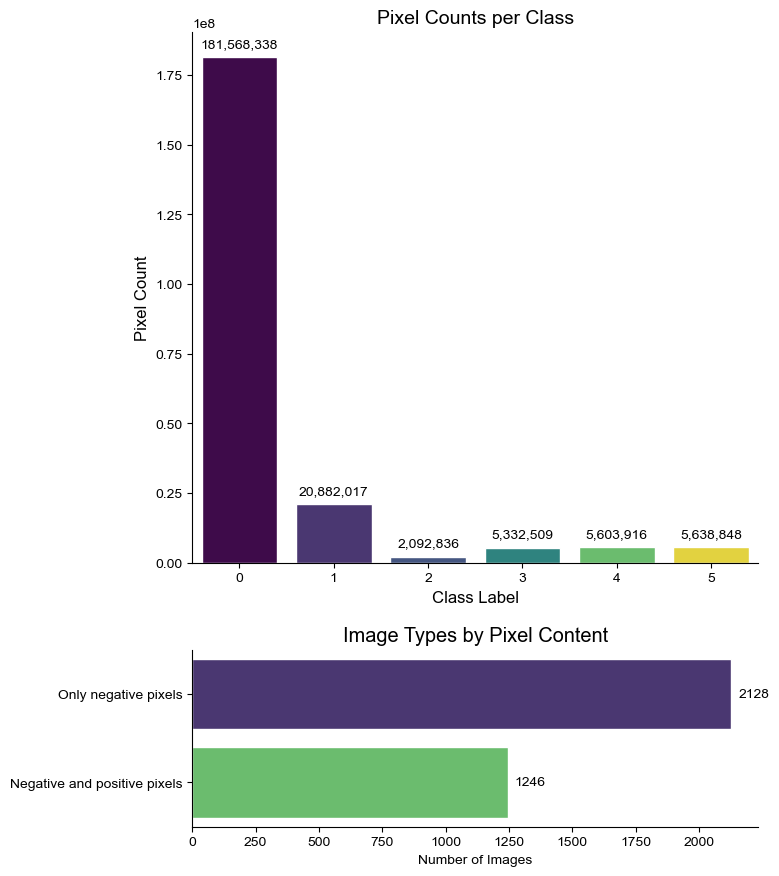

In [9]:
eda = DataExplorer(tiles_dict)

eda.count_mask_pixels()
eda.visualize_mask_pixels()

Coverage Analysis:
Images with only white pixels: 6208
Images with black pixels (defective): 90
In defective images - White: 29.72%, Black: 70.28%


c:\Users\blanc\OneDrive\Desktop\DSDM\3-ImageProcessing\FINAL_HW\DL_improc_final_project\library\eda\eda.py:119: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
c:\Users\blanc\OneDrive\Desktop\DSDM\3-ImageProcessing\FINAL_HW\DL_improc_final_project\library\eda\eda.py:150: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


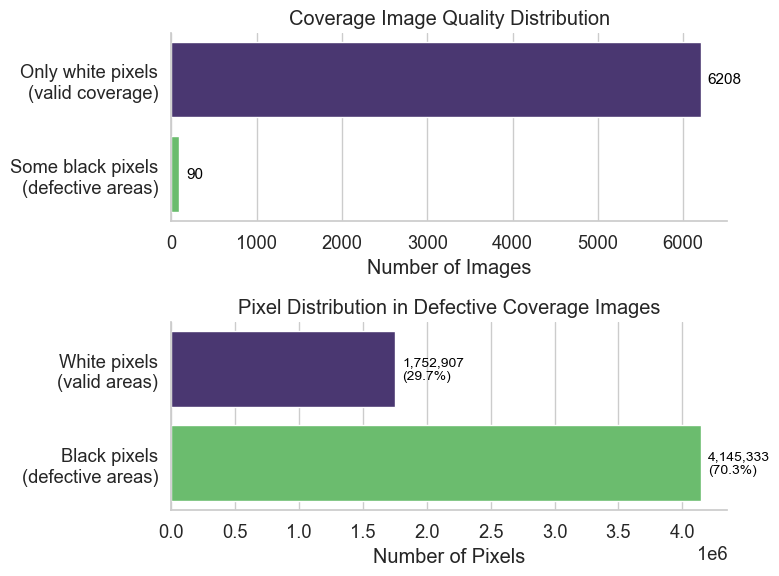

In [10]:
eda.count_coverage_pixels()
eda.visualize_coverage_pixels()

In [17]:
path = 'C:/Users/blanc/OneDrive/Desktop/DSDM/3-ImageProcessing/FINAL_HW/tiled_labelled_dataset\\EMSR213_06MONREALE_02GRADING_MAP_v2_vector\\coverages\\sentinel2_2017-07-20_coverage_tile_2_9.png'

# Get the filename without extension
filename = os.path.splitext(os.path.basename(path))[0]
# filename = 'sentinel2_2017-07-20_coverage_tile_2_9'

# Split by underscore
parts = filename.split('_')
# parts = ['sentinel2', '2017', '07', '20', 'coverage', 'tile', '2', '9']

# Extract satellite_date_id (first 4 parts)
satellite_date_id = '_'.join(parts[1:2])  # 'sentinel2_2017-07-20'

# Extract tile_id (last 3 parts with leading underscore)
tile_id = '_' + '_'.join(parts[-3:])  # '_tile_2_9'

print(f"satellite_date_id: {satellite_date_id}")
print(f"tile_id: {tile_id}")

satellite_date_id: 2017-07-20
tile_id: _tile_2_9


In [20]:
black_list = eda.defective_coverages_path_list
print('NUMBER OF DEFECTIVE COVERAGES:', len(black_list))

print('\nFIRST 10 DEFECTIVE COVERAGES:')
black_list[:10]

NUMBER OF DEFECTIVE COVERAGES: 90

FIRST 10 DEFECTIVE COVERAGES:


['C:/Users/blanc/OneDrive/Desktop/DSDM/3-ImageProcessing/FINAL_HW/tiled_labelled_dataset\\EMSR213_06MONREALE_02GRADING_MAP_v2_vector\\coverages\\sentinel2_2017-07-20_coverage_tile_2_9.png',
 'C:/Users/blanc/OneDrive/Desktop/DSDM/3-ImageProcessing/FINAL_HW/tiled_labelled_dataset\\EMSR213_06MONREALE_02GRADING_MAP_v2_vector\\coverages\\sentinel2_2017-07-20_coverage_tile_3_9.png',
 'C:/Users/blanc/OneDrive/Desktop/DSDM/3-ImageProcessing/FINAL_HW/tiled_labelled_dataset\\EMSR213_06MONREALE_02GRADING_MAP_v2_vector\\coverages\\sentinel2_2017-07-20_coverage_tile_4_9.png',
 'C:/Users/blanc/OneDrive/Desktop/DSDM/3-ImageProcessing/FINAL_HW/tiled_labelled_dataset\\EMSR213_06MONREALE_02GRADING_MAP_v2_vector\\coverages\\sentinel2_2017-07-20_coverage_tile_5_9.png',
 'C:/Users/blanc/OneDrive/Desktop/DSDM/3-ImageProcessing/FINAL_HW/tiled_labelled_dataset\\EMSR213_06MONREALE_02GRADING_MAP_v2_vector\\coverages\\sentinel2_2017-07-20_coverage_tile_6_8.png',
 'C:/Users/blanc/OneDrive/Desktop/DSDM/3-ImageProc

In [24]:
for p in black_list:
    f = os.path.splitext(os.path.basename(p))[0]
    parts = f.split('_')

    tile_id = '_' + '_'.join(parts[-3:])  # '_tile_2_9'

    path = Path(p)

    parent_folder = path.parent.parent
    
    # Go through all subdirectories (coverages, masks, images)
    for subdir in parent_folder.iterdir():
        if subdir.is_dir():
            
            # Look for files containing the tile_id in their filename
            for file in subdir.iterdir():
                if file.is_file() and tile_id in file.name:
                    try:
                        file.unlink()  # Delete the file
                    except Exception as e:
                        print(f"    ✗ Error deleting {file.name}: {e}")
    
print(f"All faulty images deleted ✓")

All faulty images deleted ✓


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00029999999..7.167].


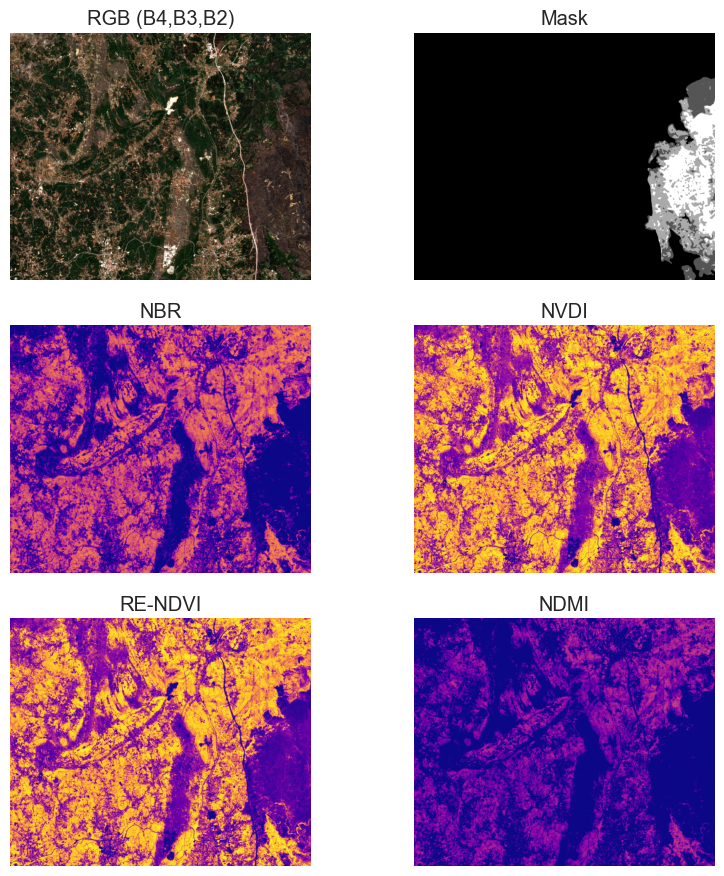

In [10]:
train_visualizer.visualize_indices()

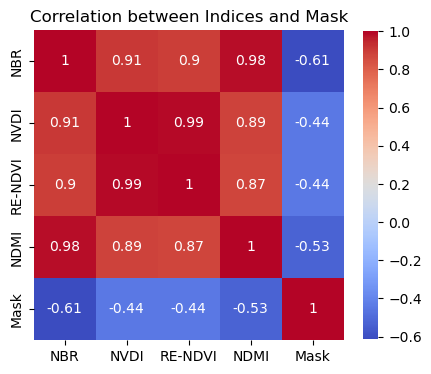

In [ ]:
train_visualizer.visualize_correlations()

Sampling 10000 pixels from up to 50 Sentinel-2 images...


Processing Sentinel-2 images: 100%|██████████| 50/50 [00:01<00:00, 28.57it/s]
c:\Users\blanc\OneDrive\Desktop\DSDM\3-ImageProcessing\FINAL_HW\DL_improc_final_project\library\eda\eda.py:189: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(


<Figure size 1500x800 with 0 Axes>

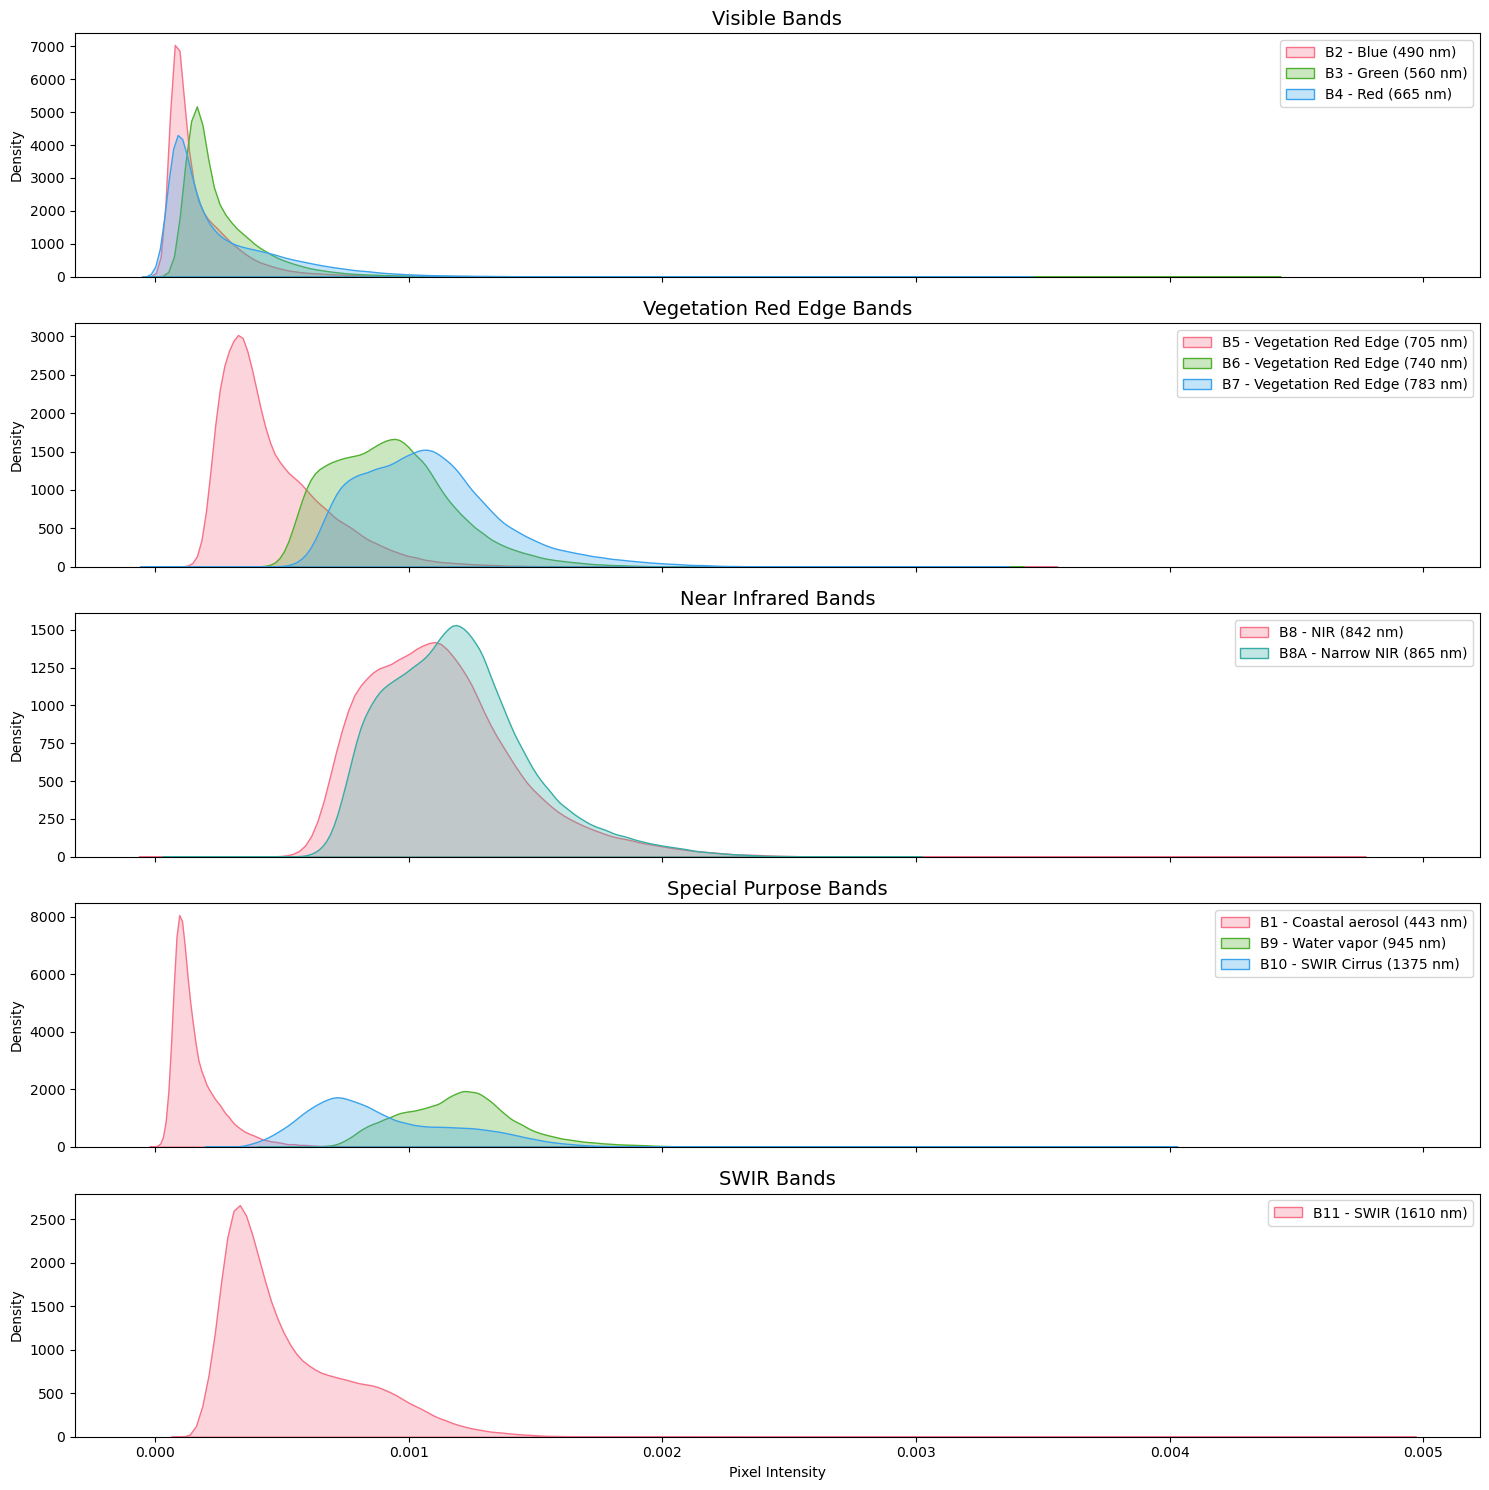

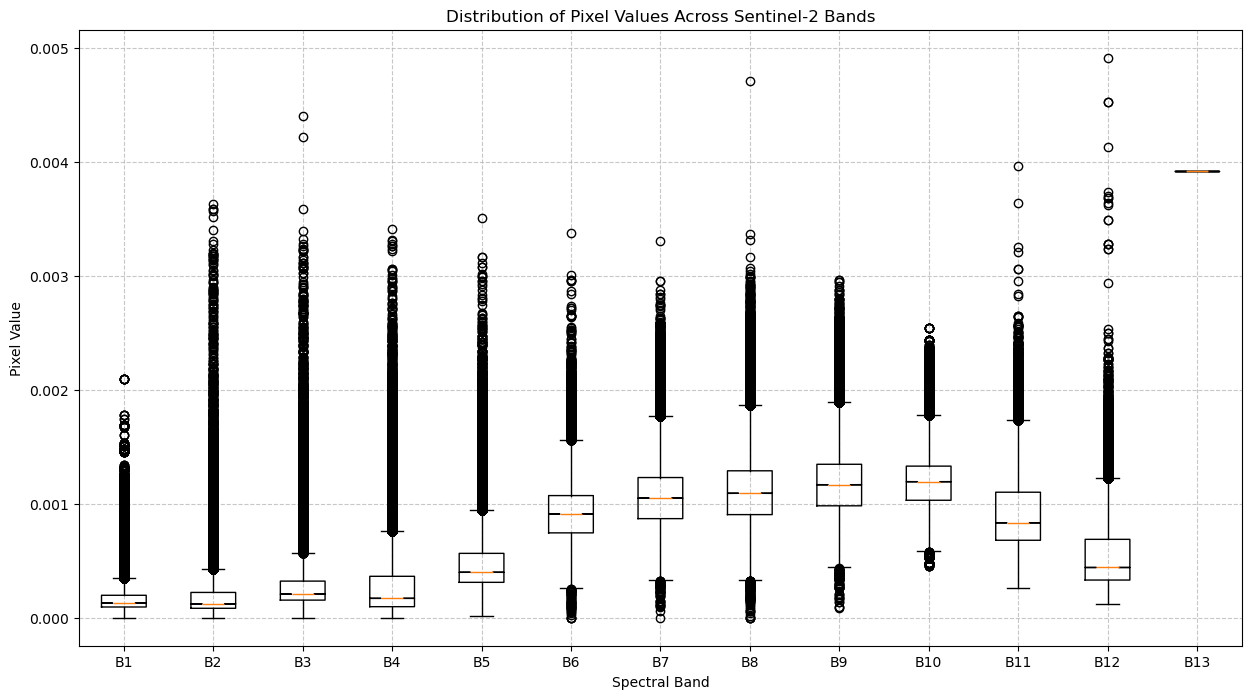

In [21]:
eda.plot_sentinel2_bands_distribution()

In [22]:
Path(os.path.join(cwd, 'tiled_fire_dataset')).exists()

NameError: name 'cwd' is not defined